In [1]:
import os
import warnings
import sys
import codecs
import numpy as np
import argparse
import json
import pickle

from util import read_passages, evaluate, make_folds, clean_words, test_f1, to_BIO, from_BIO, from_BIO_ind, arg2param

from keras.activations import softmax
from keras.regularizers import l2
from keras.models import Model, model_from_json
from keras.layers import Input, LSTM, Dense, Dropout, TimeDistributed, Bidirectional
from keras.callbacks import EarlyStopping,LearningRateScheduler, ModelCheckpoint
from keras.optimizers import Adam, RMSprop, SGD
from crf import CRF
from attention import TensorAttention
from custom_layers import HigherOrderTimeDistributedDense
from generator import BertDiscourseGenerator
from keras_bert import load_trained_model_from_checkpoint, Tokenizer

from discourse_tagger_generator_bert import PassageTagger

import matplotlib.pyplot as plt
from scipy.special import softmax
from matplotlib import transforms

Using TensorFlow backend.


In [2]:
use_attention = True
att_context = "LSTM_clause"
bidirectional = bid = True
crf = True
lstm = False
maxseqlen = 40
maxclauselen = 60
input_size = 768
embedding_dropout=0.4 
high_dense_dropout=0.4
attention_dropout=0.6
lstm_dropout=0.5
word_proj_dim=300 
hard_k=0 
lstm_dim = 350 
rec_hid_dim = 75 
att_proj_dim = 200 
batch_size = 10
reg=0


In [29]:
prefix="scidt_scibert/"
model_ext = "att=%s_cont=%s_lstm=%s_bi=%s_crf=%s"%(str(use_attention), att_context, str(lstm), str(bid), str(crf))
model_config_file = open(prefix+"model_%s_config.json"%model_ext, "r")
model_weights_file_name = prefix+"model_%s_weights"%model_ext
model_label_ind = prefix+"model_%s_label_ind.json"%model_ext
label_ind_json = json.load(open(model_label_ind))
label_ind = {k: int(label_ind_json[k]) for k in label_ind_json}
num_classes = len(label_ind)

In [30]:
if use_attention:
    inputs = Input(shape=(maxseqlen, maxclauselen, input_size))
    x = Dropout(embedding_dropout)(inputs)
    x = HigherOrderTimeDistributedDense(input_dim=input_size, output_dim=word_proj_dim, reg=reg)(x)
    att_input_shape = (maxseqlen, maxclauselen, word_proj_dim)
    x = Dropout(high_dense_dropout)(x)
    x, raw_attention = TensorAttention(att_input_shape, context=att_context, hard_k=hard_k, proj_dim = att_proj_dim, rec_hid_dim = rec_hid_dim, return_attention=True)(x)
    x = Dropout(attention_dropout)(x)
else:
    inputs = Input(shape=(maxseqlen, input_size))
    x = Dropout(embedding_dropout)(inputs)
    x = TimeDistributed(Dense(input_dim=input_size, units=word_proj_dim))

if bidirectional:
    x = Bidirectional(LSTM(input_shape=(maxseqlen,word_proj_dim), units=lstm_dim, 
                                  return_sequences=True,kernel_regularizer=l2(reg),
                                  recurrent_regularizer=l2(reg), 
                                  bias_regularizer=l2(reg)))(x)
    x = Dropout(lstm_dropout)(x) 
elif lstm:
    x = LSTM(input_shape=(maxseqlen,word_proj_dim), units=lstm_dim, return_sequences=True,
                    kernel_regularizer=l2(reg),
                    recurrent_regularizer=l2(reg), 
                    bias_regularizer=l2(reg))(x)
    x = Dropout(lstm_dropout)(x) 

if crf:
    Crf = CRF(num_classes,learn_mode="join")
    discourse_prediction = Crf(x)
    tagger = Model(inputs=inputs, outputs=[discourse_prediction])        
else:
    discourse_prediction = TimeDistributed(Dense(num_classes, activation='softmax'),name='discourse')(x)
    tagger = Model(inputs=inputs, outputs=[discourse_prediction])

In [31]:
tagger.load_weights(model_weights_file_name)


In [32]:
tagger.layers[-1].name

'crf_2'

In [33]:
weights = tagger.layers[-1].get_weights()

In [34]:
reverse_ind = {i: l for (l, i) in label_ind.items()}

In [35]:
transition_weight = weights[1]

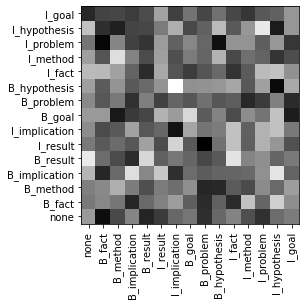

In [36]:
plt.figure()
label_size = len(reverse_ind)
plt.imshow(transition_weight,cmap="gray",aspect="equal")
plt.xticks(range(label_size), [reverse_ind[i] for i in range(label_size)], rotation='vertical')
plt.yticks(range(label_size), [reverse_ind[i] for i in range(label_size)])
plt.ylim([-0.5,label_size-0.5])
#plt.colorbar()
#plt.title("linear chain CRF weight")
#plt.show()
filename = "CRF.pdf"
plt.savefig(filename,quality=100,bbox_inches='tight')